<hr style="border:2px solid gray">

# Test set evaluation
*Task:* We will evaluate `SVR` and `RandomForestRegressor` on the test set:

***Contributors***
- Adam
- Hernan

<hr style="border:2px solid gray">


### Importing modules

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from airbnb_preperation import airbnb_preperation

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error

### Loading in the data

In [14]:
Xtrain, ytrain, Xdev, ydev, Xtest, ytest = airbnb_preperation('./Data')

Dropped 414 outliers


Combining train/dev sets into one train set

In [15]:
Xtrain = pd.concat([Xtrain, Xdev], axis=0)
ytrain = pd.concat([ytrain, ydev], axis=0)

In [16]:
score_table = pd.DataFrame(columns=['R^2 (train)', 'R^2 (test)', 'MNSE (train)', 'MNSE (test)', 'Error Rate (train)', 'Error Rate (test)'])

### Support vector regression

The best hyperparameter:
{'kernel': 'rbf'}

In [17]:
%%time
SVR = SVR(kernel='rbf')
SVR.fit(Xtrain, ytrain)

SVR_r2_train = SVR.score(Xtrain, ytrain)
SVR_r2_test = SVR.score(Xtest, ytest)

SVR_train_pred = SVR.predict(Xtrain)
SVR_test_pred = SVR.predict(Xtest)

SVR_MSE_train = mean_squared_error(ytrain, SVR_train_pred)
SVR_MSE_test = mean_squared_error(ytest, SVR_test_pred)

SVR_ER_train = f'{round(100 * mean_absolute_error(ytrain, SVR_train_pred) / ytrain.mean(), 2)}%'
SVR_ER_test = f'{round(100 * mean_absolute_error(ytest, SVR_test_pred) / ytest.mean(), 2)}%'

scores= [SVR_r2_train, SVR_r2_test, SVR_MSE_train, SVR_MSE_test, SVR_ER_train, SVR_ER_test]

score_table.loc['Support Vector Regression'] = scores


CPU times: total: 6min 39s
Wall time: 7min 34s


### Random forest regression

The best hyperparameter:
{'bootstrap': False, 'max_depth': 15, 'max_features': 1.0, 'min_samples_leaf': 16, 'min_samples_split': 2, 'n_estimators': 10}

In [18]:
Xtrain, ytrain, Xdev, ydev, Xtest, ytest = airbnb_preperation('./Data', keep_outliers=True) #Reloading the data, but without dropping outliers
Xtrain = pd.concat([Xtrain, Xdev], axis=0)
ytrain = pd.concat([ytrain, ydev], axis=0)

In [19]:
%%time
params = {'bootstrap': False, 'max_depth': 15, 'max_features': 1.0, 'min_samples_leaf': 16, 'min_samples_split': 2, 'n_estimators': 10}
RFR = RandomForestRegressor(**params)
RFR.fit(Xtrain, ytrain)

RFR_r2_train = RFR.score(Xtrain, ytrain)
RFR_r2_test = RFR.score(Xtest, ytest)

RFR_train_pred = RFR.predict(Xtrain)
RFR_test_pred = RFR.predict(Xtest)

RFR_MSE_train = mean_squared_error(ytrain, RFR_train_pred)
RFR_MSE_test = mean_squared_error(ytest, RFR_test_pred)

RFR_ER_train = f'{round(100 * mean_absolute_error(ytrain, RFR_train_pred) / ytrain.mean(), 2)}%'
RFR_ER_test = f'{round(100 * mean_absolute_error(ytest, RFR_test_pred) / ytest.mean(), 2)}%'

scores= [RFR_r2_train, RFR_r2_test, RFR_MSE_train, RFR_MSE_test, RFR_ER_train, RFR_ER_test]

score_table.loc['Random Forest Regression'] = scores


CPU times: total: 9.91 s
Wall time: 12.6 s


In [20]:
score_table

,R^2 (train),R^2 (test),MNSE (train),MNSE (test),Error Rate (train),Error Rate (test)
Support Vector Regression,0.768995,0.678871,0.015210,0.021824,3.85%,4.54%
Random Forest Regression,0.800843,0.551493,0.013328,0.030481,3.54%,5.59%


### Residual analysis

Support Vector Regression

CPU times: total: 20 s
Wall time: 22.9 s


Text(0.5, 1.0, 'Residuals for Support Vector Regression')

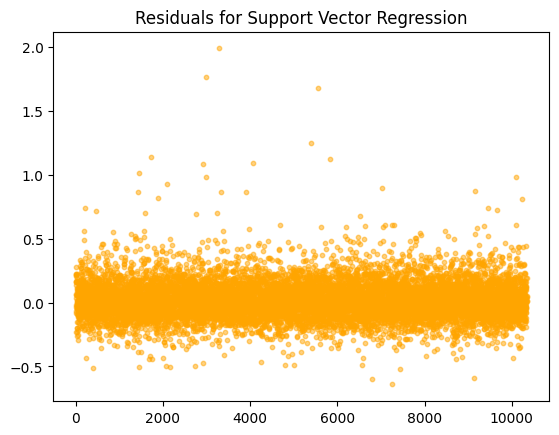

In [21]:
%%time
SVR_residuals = ytest - SVR.predict(Xtest)
plt.scatter(np.arange(len(SVR_residuals)), SVR_residuals, alpha=0.5, s=10, c='orange' )
plt.title('Residuals for Support Vector Regression')

Random Forest Regression

Text(0.5, 1.0, 'Residuals for Random Forest Regression')

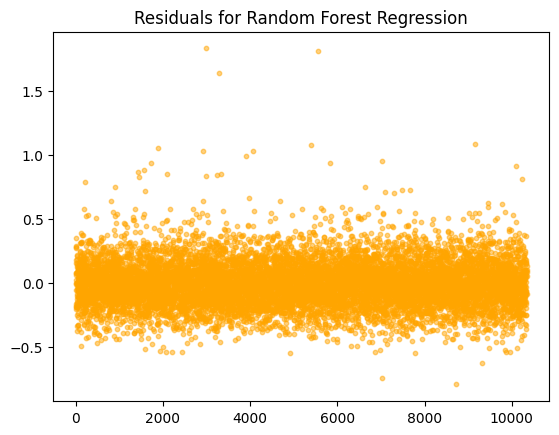

In [22]:
RFR_residuals = ytest - RFR.predict(Xtest)
plt.scatter(np.arange(len(RFR_residuals)), RFR_residuals, alpha=0.5, s=10, c='orange' )
plt.title('Residuals for Random Forest Regression')

In [23]:
ytest.loc[list(RFR_residuals.loc[lambda x : x>1].index)]

27901    3.530924
43997    3.359169
27638    4.080941
31635    4.111582
39498    3.359258
24353    3.713207
48215    4.112035
1962     3.910126
Name: realSum, dtype: float64

The 4 largest residuals are of the luxorious rentals which include 3 rentals priced at over ten thousand dollars a night. Our model does poorly predicting the price of these properties. However, most properties it performs much better. The goal of this project was to build a tool which can predict the price of airbnbs, providing renters an appropriate price range for their property. Since this was our goal, we are more concerned with the average properties, and as such, the most useful metric for our models is the median absolute error. Let's compare this for both models. 

In [24]:
RFR_MAE_log = median_absolute_error(ytest, RFR.predict(Xtest))
RFR_MAE_log

0.1037290030922362

This statistic is unhelpful as it is in a log scale, let's convert it back to dollars.

In [25]:
ytest_dollars = 10**ytest
RFR_pred_dollars = 10**(RFR.predict(Xtest) )
RFR_MAE_dollars = median_absolute_error(ytest_dollars, RFR_pred_dollars)
print(f'Median absolute error for Random forest Regression (dollars): {RFR_MAE_dollars}')

Median absolute error for Random forest Regression (dollars): 50.54758903637253


In [26]:
SVR_pred_dollars = 10**(SVR.predict(Xtest))
SVR_MAE_dollars = median_absolute_error(ytest_dollars, SVR_pred_dollars)
print(f'Median absolute error for Support vector regression (dollars): {SVR_MAE_dollars}')

Median absolute error for Support vector regression (dollars): 37.56819948133638
